In [1]:
from fastai.vision import *
import sys

import pose
import models.cs_v2 as cs
%load_ext autoreload
%autoreload 2

In [2]:
root = Path('../../LIP').resolve()
pose_label = pose.LIPLabel(root /'pose_annotations')
transforms = [pose.pose_flip_lr(p=0.5)], None
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=128, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=64)
        .normalize(imagenet_stats))

data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [3]:
class DetectVisibleInstuctor(cs.BaseInstructor):
    def __init__(self, n_inst, thresh):
        self.n_inst = n_inst
        self.thresh = thresh
        
    def on_batch_begin(self, last_target, train, **kwargs):
        if train:
            self.gt_visible = last_target[..., 2]
            self.train = True
        else:
            self.train = False
            
    def next_inst(self, bu_out):
        if self.train:
            return self.gt_visible.clamp(0, 1), False
        inst = torch.where(bu_out > self.thresh, bu_out.new_ones(1), bu_out.new_zeros(1))
        return inst, False


def loss(outputs, targets):
    bu, td = outputs
    is_visible = targets[..., 2] > 0
    bu_loss = F.binary_cross_entropy_with_logits(bu, is_visible.float())
    
    gt = targets[is_visible][..., :2]
    td_loss = pose.ce_loss(td[is_visible], gt)
    return bu_loss + td_loss

In [4]:
nk = 16
thresh = 0.8
def acc(last_output, last_target):
    return accuracy_thresh(last_output[0], last_target[..., 2].clamp(0, 1), thresh=thresh)
acc.name = f'accuracy@{thresh}'

instructor = DetectVisibleInstuctor(nk, thresh)
learner = cs.cs_learner(data, models.resnet18, nk, instructor, bu_c=nk, td_laterals=False, embedding=nn.Linear,
                        loss_func=loss, callback_fns=pose.Pckh, metrics=acc)

In [5]:
learner.lr_find()

epoch,train_loss,valid_loss,acc,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-03
Min loss divided by 10: 5.25E-02


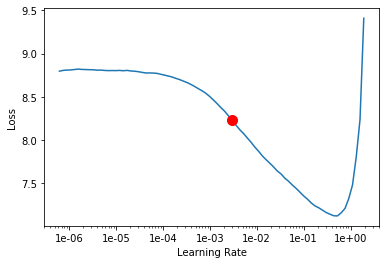

In [6]:
learner.recorder.plot(suggestion=True)

In [7]:
lr = 3e-2
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,acc,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.381052,4.278030,0.806844,0.801566,0.632197,0.445680,0.414058,0.392604,0.388834,0.454954,0.578105,0.513226,00:53
1,4.263888,4.337335,0.683850,0.806202,0.625545,0.465111,0.406818,0.417385,0.408157,0.432222,0.580615,0.518508,00:54
2,4.117740,5.212838,0.391794,0.731352,0.532158,0.313002,0.310267,0.208876,0.202428,0.329256,0.477001,0.386331,00:55
3,4.190612,4.176158,0.783337,0.792551,0.646518,0.480866,0.470105,0.407207,0.455795,0.479869,0.601557,0.540972,00:53
4,3.944859,4.724565,0.776825,0.828457,0.690021,0.531740,0.490719,0.451797,0.464062,0.500087,0.639381,0.574222,00:51
5,3.823676,3.795280,0.815313,0.847362,0.719039,0.578616,0.550714,0.472163,0.513177,0.543099,0.677605,0.611634,00:50
6,3.709853,3.571943,0.851631,0.864723,0.743526,0.625163,0.584474,0.518303,0.542884,0.552672,0.707869,0.642017,00:50
7,3.605781,3.485479,0.861275,0.870956,0.762697,0.644443,0.607701,0.534970,0.555285,0.565522,0.724657,0.657814,00:50
8,3.514885,3.452096,0.858300,0.873944,0.774703,0.652751,0.623144,0.543113,0.571411,0.577419,0.734260,0.668263,00:50
9,3.458791,3.487551,0.830638,0.869153,0.769484,0.645663,0.619286,0.539507,0.570681,0.576267,0.729025,0.664274,00:50


In [9]:
learner.save('bu_multilabel-stage1', return_path=True)

PosixPath('/home/labs/waic/omrik/LIP/models/bu_multilabel-stage1.pth')

In [11]:
learner.load('bu_multilabel-stage1')

Learner(data=ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None, model=CounterStream(
  (bu_body): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padd

In [12]:
learner.unfreeze()

epoch,train_loss,valid_loss,acc,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.02E-06


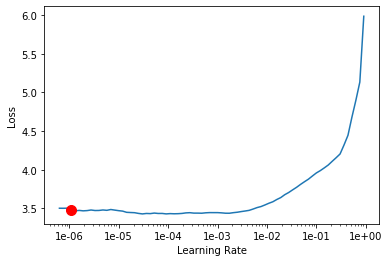

In [13]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [14]:
learner.fit_one_cycle(10, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,acc,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,3.469744,3.502723,0.831625,0.867608,0.768338,0.649074,0.618497,0.545195,0.576596,0.580137,0.728971,0.666252,00:51
1,3.520373,3.579195,0.795644,0.863641,0.758724,0.634092,0.614614,0.527418,0.573687,0.571788,0.720891,0.657336,00:50
2,3.482763,3.417180,0.885225,0.876571,0.776682,0.669732,0.631964,0.547588,0.596471,0.590581,0.741726,0.678093,00:51
3,3.437587,3.387872,0.871813,0.878580,0.782112,0.681314,0.637019,0.575349,0.609830,0.603270,0.747696,0.688996,00:50
4,3.331825,3.406232,0.841244,0.874511,0.785611,0.677939,0.638885,0.571198,0.607132,0.607424,0.747162,0.688147,00:57
5,3.258416,3.348981,0.872156,0.881568,0.795590,0.692341,0.652666,0.586166,0.623765,0.617243,0.758367,0.700450,00:50
6,3.175945,3.365525,0.849469,0.877602,0.793289,0.691430,0.651660,0.583874,0.625756,0.620958,0.756284,0.699469,00:51
7,3.055011,3.349059,0.871169,0.882444,0.803891,0.702524,0.660786,0.592528,0.637494,0.631101,0.765166,0.708806,00:56
8,2.984663,3.348000,0.876688,0.884968,0.803790,0.705716,0.661908,0.597978,0.638618,0.631632,0.766835,0.710858,00:56
9,2.954236,3.394383,0.879681,0.885174,0.804622,0.705301,0.661757,0.597112,0.638023,0.633263,0.766968,0.710907,00:52


In [15]:
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=224, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=32)
        .normalize(imagenet_stats))

learner.data = data

epoch,train_loss,valid_loss,acc,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 4.37E-04


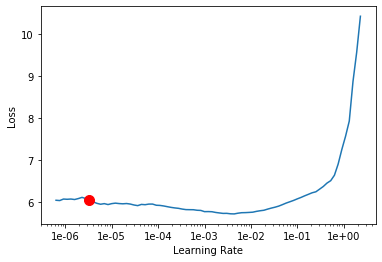

In [16]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [17]:
learner.fit_one_cycle(20, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,acc,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.484345,4.244709,0.846937,0.897332,0.811831,0.708835,0.685487,0.564253,0.598845,0.567194,0.778495,0.701101,01:18
1,4.395927,4.118557,0.872988,0.902586,0.824940,0.726712,0.700109,0.599282,0.636338,0.622105,0.791102,0.724726,01:14
2,4.299688,4.279927,0.774200,0.886874,0.801128,0.709502,0.681709,0.574034,0.603468,0.598160,0.772297,0.702625,01:15
3,4.286295,4.148576,0.848031,0.902586,0.819659,0.735282,0.701871,0.597262,0.645598,0.634103,0.792264,0.727578,01:20
4,4.293782,4.222708,0.859050,0.896765,0.815635,0.717791,0.693568,0.583461,0.620000,0.618007,0.783463,0.715143,01:16
5,4.251733,4.095892,0.838212,0.903513,0.829375,0.744881,0.713839,0.617761,0.650684,0.650562,0.800238,0.737985,01:20
6,4.172799,4.122555,0.829025,0.901710,0.833289,0.742676,0.710124,0.608572,0.664288,0.656543,0.799330,0.738381,01:17
7,4.101226,4.026200,0.903631,0.907171,0.839026,0.751122,0.724421,0.623979,0.678387,0.685395,0.807730,0.750733,01:19
8,4.032659,4.071815,0.861744,0.905574,0.837049,0.754032,0.726855,0.628141,0.682569,0.671448,0.808091,0.750626,01:18
9,3.957018,4.094722,0.827081,0.903410,0.834755,0.755756,0.723183,0.628259,0.688440,0.676889,0.806475,0.750956,01:15


epoch,train_loss,valid_loss,acc,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


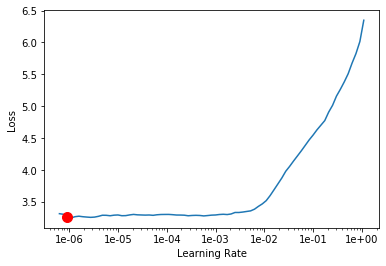

In [18]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(10, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,acc,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,3.225065,4.314352,0.866856,0.908768,0.850307,0.773675,0.739372,0.639556,0.708863,0.704799,0.820111,0.766621,01:32
1,3.240629,4.321497,0.873219,0.906862,0.849262,0.773890,0.736532,0.641523,0.708334,0.706177,0.818722,0.766143,01:14
2,3.252116,4.319624,0.881688,0.908768,0.849836,0.774984,0.737449,0.643268,0.709670,0.704249,0.819857,0.767066,01:19
3,3.237770,4.339481,0.879663,0.907840,0.848322,0.773649,0.738182,0.639395,0.706238,0.702313,0.819069,0.765360,01:21
4,3.231234,4.355493,0.880219,0.907995,0.846651,0.772870,0.738798,0.637481,0.704548,0.699767,0.818642,0.764322,01:19
5,3.195042,4.415075,0.875906,0.905007,0.846707,0.770841,0.735676,0.637917,0.702046,0.703622,0.816639,0.763251,01:18
6,3.167128,4.407539,0.880581,0.906037,0.845767,0.772787,0.737563,0.638298,0.705789,0.705490,0.817600,0.764569,01:14
7,3.139177,4.454142,0.889262,0.907171,0.848531,0.771206,0.736840,0.637369,0.703947,0.700852,0.818041,0.763976,01:23
8,3.106645,4.467559,0.877513,0.905368,0.846076,0.770877,0.735784,0.636329,0.701059,0.699534,0.816612,0.762435,01:23
